### HDB Resale Prices Dataset

<b>Data</b>: HDB resale property transactions. This comes in several separate datasets, differentiated by the date of the transaction. 
- We will first have to merge them together, and then use geocoding APIs to obtain the geographic coordinates of a flat’s location given its address (e.g., “Blk 175 Yishun Ave 7” becomes (1.437854, 103.832516)).

<b>Objectives</b>: Clear narrative with recommendations answering the following questions:

1. Some members of the public have written to the Straits Times Forum saying that flat sizes have gotten smaller over the years. Is this a fair observation? What data-driven insights can you share with the staffers over at the Ministry of National Development (MND) to help them craft a public response?

2. One of the Members of Parliament (MP) for Nee Soon GRC has asked the Minister if the negative media coverage on mishaps and crimes in Yishun has subsequently impacted property prices. What data-driven insights can you share to help MND prepare a reply in parliament?

In [7]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from datetime import datetime
from statistics import mean,median,mode,stdev
import re
import json
import seaborn as sns

### 1. Data Pre-processing 
#### 1.1 Pulling Data from data.gov.sg APIs

In [38]:
# Bit cumbersome because there are different APIs for different date ranges - 5 in total
def fetch_data(url):
    resp = requests.get(url)
    data = json.loads(resp.content)
    return data['result']['records']

datasets = ['2017_data','2015-16_data','2012-14_data','2000-12_data','1990-99_data']

urls = {
    datasets[0]: 'https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3&limit=200000',
    datasets[1]: 'https://data.gov.sg/api/action/datastore_search?resource_id=1b702208-44bf-4829-b620-4615ee19b57c&limit=500000',
    datasets[2]: 'https://data.gov.sg/api/action/datastore_search?resource_id=83b2fc37-ce8c-4df4-968b-370fd818138b&limit=500000',
    datasets[3]: 'https://data.gov.sg/api/action/datastore_search?resource_id=8c00bf08-9124-479e-aeca-7cc411d884c4&limit=500000',
    datasets[4]: 'https://data.gov.sg/api/action/datastore_search?resource_id=adbbddd3-30e2-445f-a123-29bee150a6fe&limit=500000'
}

data_dict = {name: fetch_data(url) for name, url in urls.items()}

In [39]:
# note we cannot assume the columns pulled from different APIs are the same - so we'll compare them first

s1 = set(data_dict['2017_data'][0].keys())
s2 = set(data_dict['2015-16_data'][0].keys())
s3 = set(data_dict['2012-14_data'][0].keys())
s4 = set(data_dict['2000-12_data'][0].keys())
s5 = set(data_dict['1990-99_data'][0].keys())

col = [s1,s2,s3,s4,s5]
for i in range(5):
    for j in range(5):
        if col[i] == col[j] and i<j:
            print('s'+str(i+1)+' and '+'s'+str(j+1)+' are equal')   
            
# observe that the 2015-16 and 2017 sets have the same columns, and 1990-2014 sets have the same columns. 
print(s1-s3,s3-s1) 

# observe that the 1990-2014 sets (s3, s4, s5) are missing a 'remaining_lease' column
def standardize_columns(hdb_dict):
    for i in range(len(hdb_dict)):
        hdb_dict[i]['remaining_lease'] = 'nil'

standardize_columns(data_dict['2012-14_data'])
standardize_columns(data_dict['2000-12_data'])
standardize_columns(data_dict['1990-99_data'])

s1 and s2 are equal
s3 and s4 are equal
s3 and s5 are equal
s4 and s5 are equal
{'remaining_lease'} set()


In [94]:
# convert to pandas dataframe
df = pd.DataFrame()
for i in datasets:
    df = pd.concat([df, pd.DataFrame.from_dict(data_dict[i])])
df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block
0,TOA PAYOH,5 ROOM,Improved,121,LOR 1 TOA PAYOH,878000,2018-05,79 years 09 months,1999,16 TO 18,1,153A
1,TOA PAYOH,5 ROOM,DBSS,114,LOR 1A TOA PAYOH,890888,2018-05,93 years,2012,19 TO 21,2,138C
2,TOA PAYOH,5 ROOM,DBSS,114,LOR 1A TOA PAYOH,960000,2018-05,93 years,2012,31 TO 33,3,139A
3,TOA PAYOH,5 ROOM,DBSS,114,LOR 1A TOA PAYOH,960000,2018-05,93 years,2012,31 TO 33,4,139B
4,TOA PAYOH,5 ROOM,DBSS,114,LOR 1A TOA PAYOH,966000,2018-05,93 years,2012,34 TO 36,5,139A


#### 1.2 Data Cleaning and Feature Engineering

In [95]:
# overview of the dataset
print(df.info())

# drop unnecessary columns
df = df.drop('_id',axis=1)

# convert data types
df["floor_area_sqm"] = df['floor_area_sqm'].astype('float')
df["resale_price"] = df['resale_price'].astype('float')
df['month'] = pd.to_datetime(df['month'])
df['lease_commence_date'] = pd.to_datetime(df['lease_commence_date'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874560 entries, 0 to 287195
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   town                 874560 non-null  object
 1   flat_type            874560 non-null  object
 2   flat_model           874560 non-null  object
 3   floor_area_sqm       874560 non-null  object
 4   street_name          874560 non-null  object
 5   resale_price         874560 non-null  object
 6   month                874560 non-null  object
 7   remaining_lease      165510 non-null  object
 8   lease_commence_date  874560 non-null  object
 9   storey_range         874560 non-null  object
 10  _id                  874560 non-null  int64 
 11  block                874560 non-null  object
dtypes: int64(1), object(11)
memory usage: 86.7+ MB
None


In [ ]:
# FEATURE ENGINEERING - CORRECT FOR INFLATION:
# 1. Get inflation data
df_inflation = pd.read_html("https://www.rateinflation.com/consumer-price-index/singapore-historical-cpi/")
df_inflation[0].head()
df_inflation_normalized = float(df_inflation[0][df_inflation[0]['Year'] == 2022]['nov'])/df_inflation[0]
df_inflation_normalized = df_inflation_normalized.drop('Year',axis=1)
df_inflation_normalized.index = df_inflation[0]['Year']
df_inflation_normalized.loc[2022]['dec'] = 1
df_inflation_normalized.columns = [1,2,3,4,5,6,7,8,9,10,11,12,'Annual']

# 2. Append a column for inflation
df['inflation'] = 1.0
yr = 0
mth = 0
for i in range(0,len(df)):
    yr = df['month'].dt.year.iloc[0]
    mth = df['month'][i].dt.month.iloc[0]
    df['inflation'][i] = df_inflation_normalized.loc[yr][mth]
    
# 3. Multiply by inflation; and can drop column if necessary. (this step can also be decluttered lol)
df['resale_price_with_inf'] = df['resale_price'] * df['inflation']
df = df.drop(['resale_price','inflation'],axis=1)

# FEATURE ENGINEERING - PRICE/SQM
df_hdb_price['resale_price/sqm'] = df_hdb_price['resale_price_with_inf']/df_hdb_price['floor_area_sqm']

#### 1.3 Geocoding done separately (because of the length of API calls - takes hours to run) 
- see 'Geocoding APIs (HDB Resale Dataset)'
- showing the o/p from Geocoding below

In [162]:
df = pd.read_csv("hdb_prices_geocoded.csv", index_col = 0)
df.head(1)

<ipython-input-162-178e73267a0b>:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("hdb_prices_geocoded.csv", index_col = 0)


,latitude,longitude,address,town,flat_type,flat_model,floor_area_sqm,month,remaining_lease,lease_commence_date,storey_range,resale_price_with_inf,resale_price/sqm
0,1.377259,103.748292,818B CHOA CHU KANG AVE 1,CHOA CHU KANG,4 ROOM,Model A,92.0,2022-12-01,93.833333,2017,19 TO 21,580000.0,6304.347826


### 2. Exploratory Data Analysis (EDA) 

#### 2.1 Analysis by Flat Types

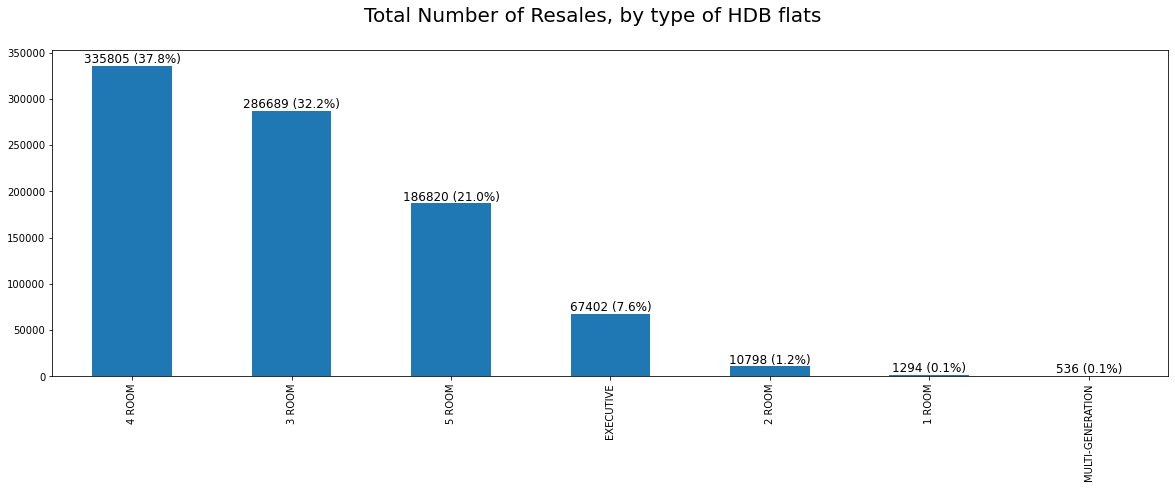

In [227]:
flat_types = df['flat_type'].value_counts()
ax = flat_types.plot(kind='bar',figsize=(20,6))
plt.suptitle('Total Number of Resales, by type of HDB flats', fontsize=20)
# Add the text labels for the values
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), str(p.get_height()) + " (" + str(round(p.get_height()*100/len(df),1)) + "%)", 
            fontsize=12, ha='center', va='bottom')

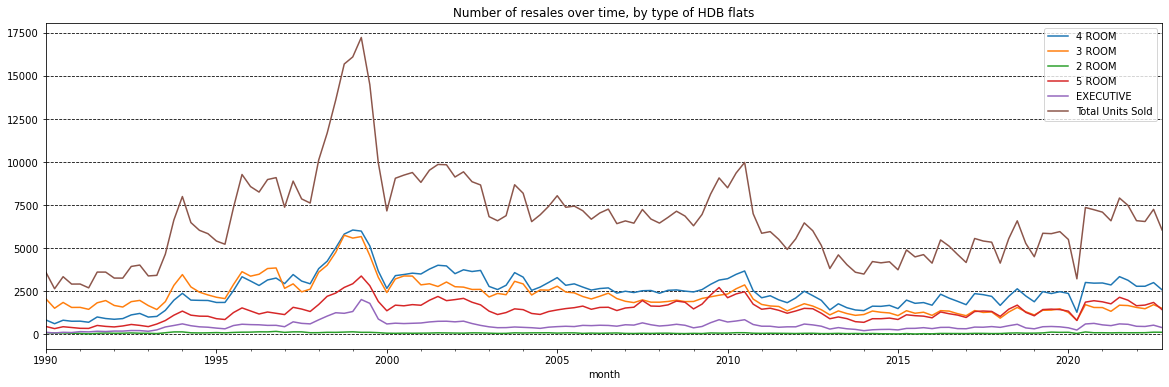

In [232]:
# units sold over time 
df_units_sold = pd.DataFrame()
for i in df['flat_type'].unique():
    df_units_sold[i] = df[df['flat_type'] == i].groupby(df["month"]).count()['town']
df_units_sold['Total Units Sold'] = df.groupby(df["month"]).count()['town']
df_units_sold = df_units_sold.drop(['1 ROOM','MULTI-GENERATION'], axis=1) # since there's a negligible number of them
df_units_sold.index = pd.to_datetime(df_units_sold.index)
df_units_sold = df_units_sold.resample('QS').sum()
df_units_sold.plot(title = 'Number of resales over time, by type of HDB flats', figsize=(20,6)).grid(color='black', linestyle='--', axis = 'y')

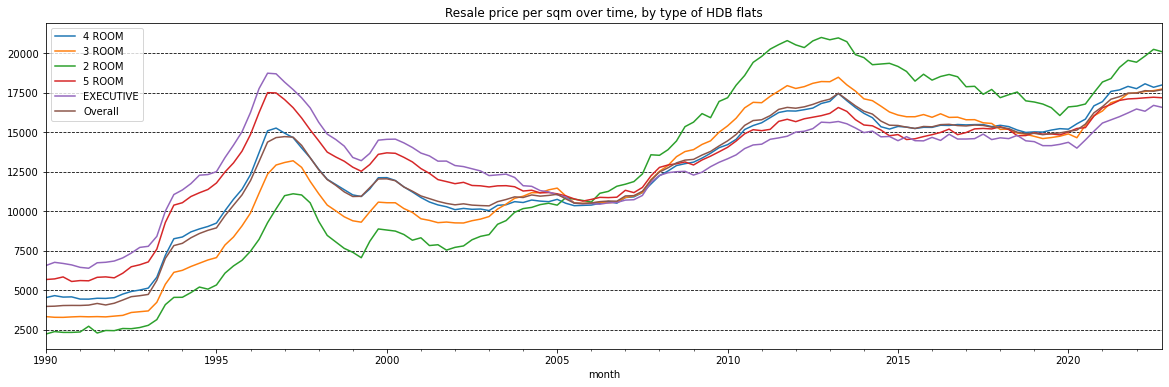

In [233]:
# real increase in property prices across the board - using price/sqm, by flat types. Data has been corrected for inflation.
df_resale_price = pd.DataFrame()
for i in df['flat_type'].unique():
    df_resale_price[i] = df[df['flat_type'] == i].groupby(df["month"]).mean(numeric_only=True)['resale_price/sqm']
df_resale_price['Overall'] = df.groupby(df["month"]).mean(numeric_only=True)['resale_price/sqm']
df_resale_price = df_resale_price.drop(['1 ROOM','MULTI-GENERATION'], axis=1)

# resample by quarter so it's smoother and removes anomalous months
df_resale_price.index = pd.to_datetime(df_resale_price.index)
df_resale_price = df_resale_price.resample('QS').sum()
df_resale_price.plot(title = 'Resale price per sqm over time, by type of HDB flats', figsize=(20,6)).grid(color='black', linestyle='--', axis = 'y')

#### 2.2 EDA - Analysis by Town

<AxesSubplot:title={'center':'Resale price per sqm, by area'}, xlabel='town'>

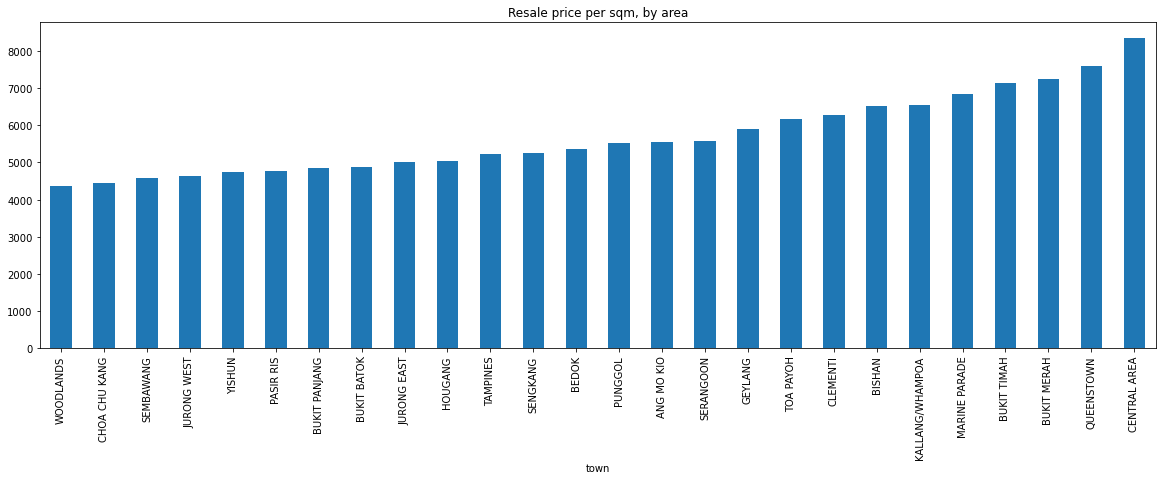

In [305]:
# resale prices, but only with more recent data (past 10 years) 
df['month'] = pd.to_datetime(df['month'])
df_town_recent = df[df['month'] > datetime(2012, 1, 1)].groupby('town').mean(numeric_only=True)
df_town_recent = df_town_recent.sort_values('resale_price/sqm', ascending = True)
df_town_recent['resale_price/sqm'].plot.bar(figsize = (20,6), title = 'Resale price per sqm, by area')

<AxesSubplot:title={'center':'Distribution of resale flat volumes by town'}>

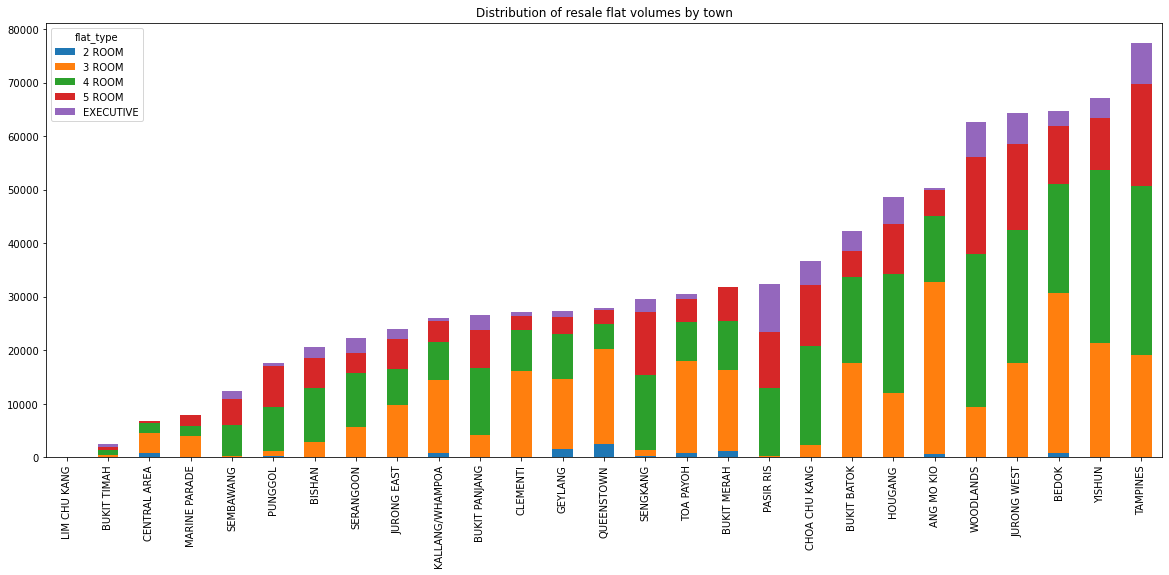

In [306]:
# distribution of resale flat volumes by town - note that this is NOT the absolute number of flats (we're not interested in that)
df_towndist = pd.DataFrame()
for i in df['town'].unique():
    df_towndist[i] = df[df['town'] == i].groupby('flat_type').count()['town']
    
row_sums = df_towndist.transpose().sum(axis=1)
sorted_df = df_towndist.transpose().loc[row_sums.sort_values().index]
sorted_df.plot.bar(title = 'Distribution of resale flat volumes by town', stacked = True, figsize = (20,8))

#### Question 1

Some members of the public have written to the Straits Times Forum saying that flat sizes have gotten smaller over the years. Is this a fair observation? What data-driven insights can you share with the staffers over at the Ministry of National Development (MND) to help them craft a public response?

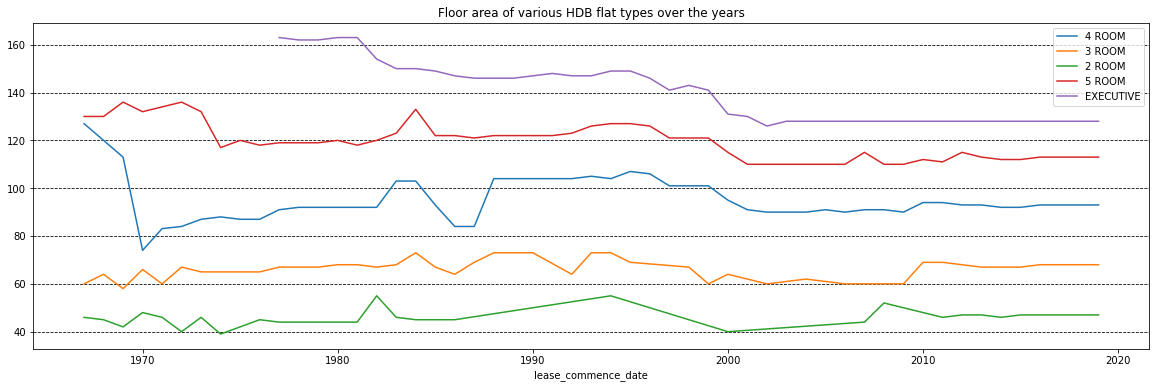

In [325]:
df_floor_area = pd.DataFrame()

# note that we will take the median floor area - so the average floor area is not distorted by outliers
for i in df['flat_type'].unique():
    df_floor_area[i] = df[df['flat_type'] == i].groupby(df["lease_commence_date"]).median(numeric_only=True)['floor_area_sqm']

df_floor_area = df_floor_area.interpolate(method='linear') # imputing data for some missing years - will flesh this out 
    
df_floor_area = df_floor_area.drop(['1 ROOM','MULTI-GENERATION'], axis=1) # since there's a negligible number of them

df_floor_area.plot(title = 'Floor area of various HDB flat types over the years', figsize=(20,6)).grid(color='black', linestyle='--', axis = 'y')

# can see that flat sizes have roughly stabilized since 2000! In line with MND's messaging

However, the above is based on floor areas new flats - since it is based on lease commencement dates. Public perception could be affected by resale flat volumes, so we will produce the same visualization, but based on the resale dates instead.


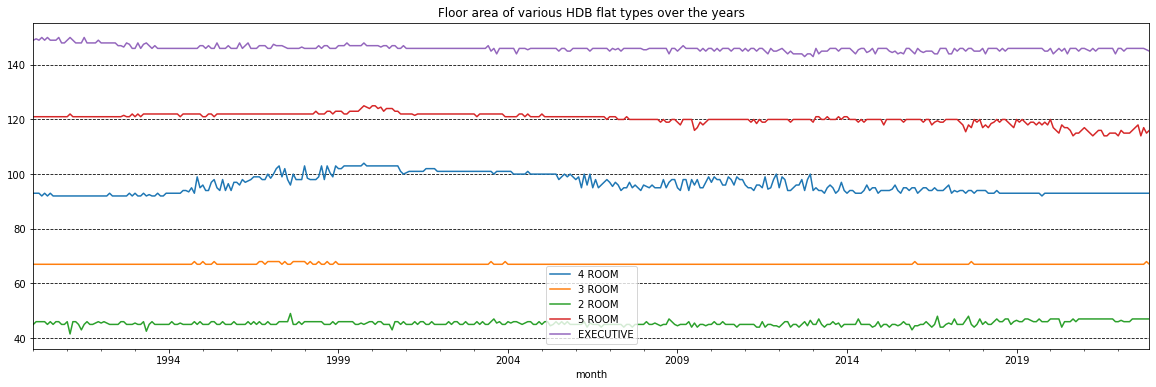

In [324]:
df_floor_area = pd.DataFrame()
# note that we will take the median floor area - so the average floor area is not distorted by outliers
for i in df['flat_type'].unique():
    df_floor_area[i] = df[df['flat_type'] == i].groupby(df["month"]).median(numeric_only=True)['floor_area_sqm']

df_floor_area = df_floor_area.interpolate(method='linear') # imputing data for some missing years - will flesh this out 
    
df_floor_area = df_floor_area.drop(['1 ROOM','MULTI-GENERATION'], axis=1) # since there's a negligible number of them

df_floor_area.plot(title = 'Floor area of various HDB flat types over the years', figsize=(20,6)).grid(color='black', linestyle='--', axis = 'y')

We can observe that 4 and 5 room flat sizes have dropped in the past twenty years! (in practice, will supplement this explanation with ppt slides)

#### Question 2
One of the Members of Parliament (MP) for Nee Soon GRC has asked the Minister if the negative media coverage on mishaps and crimes in Yishun has subsequently impacted property prices. What data-driven insights can you share to help MND prepare a reply in parliament?

<AxesSubplot:title={'center':'Resale price per sqm - Yishun vs Not Yishun'}, xlabel='month'>

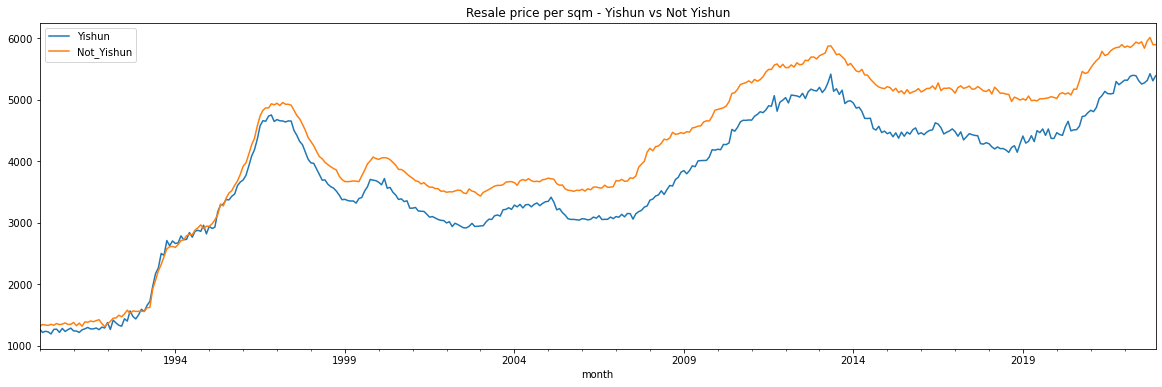

In [392]:
# similar to previous - we can apply some sort of DiD model and observe if Yishun is statistically much different from the rest! 
df_yishun = df[df['town'] == 'YISHUN'].groupby('month').mean(numeric_only=True)
df_notyishun = df[df['town'] != 'YISHUN'].groupby('month').mean(numeric_only=True)
df_compare = pd.DataFrame()
df_compare['Yishun'] = df_yishun['resale_price/sqm']
df_compare['Not_Yishun'] = df_notyishun['resale_price/sqm']
df_compare.plot(title = 'Resale price per sqm - Yishun vs Not Yishun', figsize = (20,6))

<AxesSubplot:xlabel='month'>

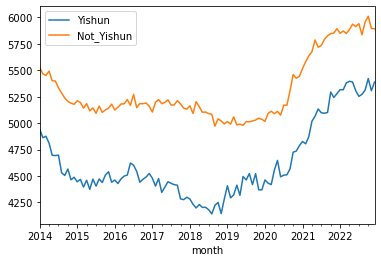

In [393]:
#zooming in to the period of negative media coverage - again nothing noticeable
df_compare.loc['2014':'2023'].plot()

In [ ]:
# further analysis possible - Difference-in-difference model, analyzing areas close to Yishun for a more accurate comparison, etc. 